# Office Items Multi-class classification

This notebook generalizes the cats and dogs example to a more complicated classification task with more classes.

## Import the necessary modules and define some helper functions

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## Define Training Configurations (args)

In [2]:
class Config:
    def __init__(self):
        self.dataset_name = "pass"
        self.dataset_fn = pass_get_datasets
        self.num_classes = 0
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 512
        self.validation_split = 0.0
        self.log_prefix = "SSL"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/PASS_dataset/"
        self.deterministic = True
        self.print_freq = 50
        self.labels = None
        self.lr = 0.001
        self.num_epochs = 100
        self.qat_policy = {'start_epoch':5, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()
conf.is_classification = False

## Set up the logger

In [3]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/SSL___2022.07.07-105355/SSL___2022.07.07-105355.log
dataset_name:pass
dataset_fn=<function pass_get_datasets at 0x7f4c03091ca0>
num_classes=0
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=512
validation_split=0.0
lr=0.001000
num_epochs=100
qat_policy={'start_epoch': 5, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and visualize the dataset

../Datasets/PASS_dataset/train


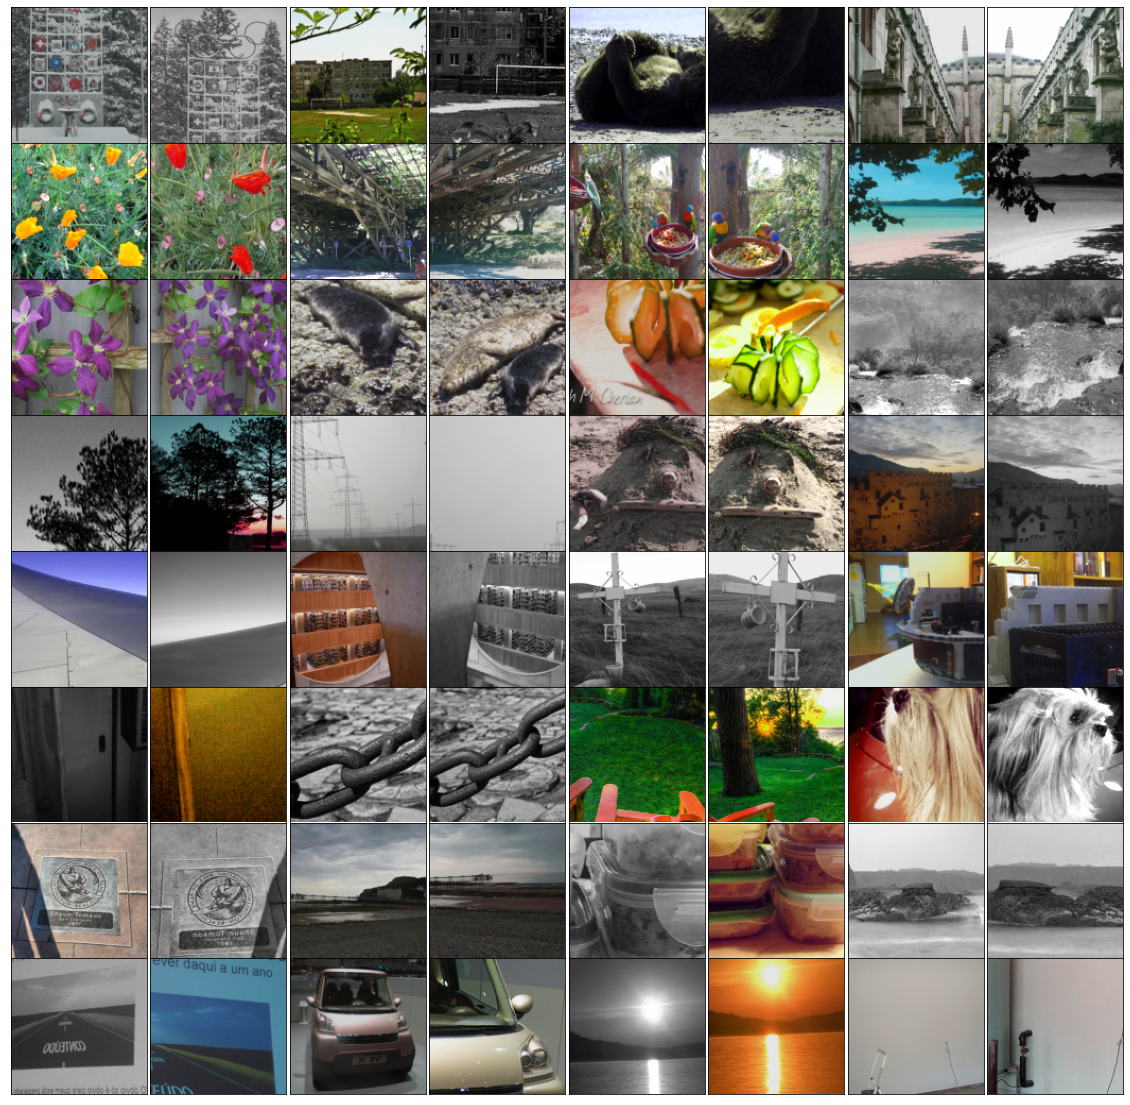

In [4]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

## Create the data loaders

In [5]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=149999
	validation=1
	test=1
Augmentations:Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.1, 0.1))
    RandomGrayscale(p=0.25)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/PASS_dataset/train
../Datasets/PASS_dataset/test


## Set up the device, cuda or cpu

In [6]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model for training

In [7]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.ClassifierBackbone()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: ClassifierBackbone(
  (conv1): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (conv2): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (

Configuring device: MAX78000, simulate=False.


Number of Model Params: 287560


## Set up optimizer, loss, and learning schedule

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device,temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(device)
        self.temperature = self.temperature.to(device)
        self.device = device
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        batch_size = self.batch_size
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(self.device)
        if emb_i.size()[0] != self.batch_size:
            batch_size = emb_i.size()[0]
            self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            self.negatives_mask = self.negatives_mask.to(self.device)

        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * batch_size)
        # print("CL: ",loss)
        return loss

In [9]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[5, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = ContrastiveLoss(conf.batch_size,conf.device,0.5).to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({5: 1, 35: 1, 100: 1}) gamma: 0.5


## Define the forward function

In [10]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    input1, input2 = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(input1), model(input2)

conf.forward = classifier_forward

## Validation Function

In [1]:
def validate(data_loader, model, loggers, conf, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # keep track of incorrect predictions
    wrong_samples = None
    wrong_preds = None
    actual_preds = None
    img_names = None

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

    # validation set info
    total_samples = len(data_loader.sampler)
    confusion = tnt.ConfusionMeter(conf.num_classes)
    total_steps = (total_samples + conf.batch_size - 1) // conf.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf.batch_size)

    # Switch to evaluation mode
    model.eval()

    class_probs = []
    class_preds = []

    try:
        # iterate over the batches in the validation set
        for validation_step, batch in enumerate(data_loader):
            with torch.no_grad():

                output, target = conf.forward(model, batch, conf)
                

                # # get the idxs of the max output
                # pred = output.argmax(dim=1, keepdim=True)
                
                # wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0] # get wrong predictions
                
                # if validation_step == 0:
                #     wrong_samples = inputs[wrong_idx]
                #     wrong_preds = pred[wrong_idx]
                #     actual_preds = target.view_as(pred)[wrong_idx]
                #     img_names = [names[i.item()] for i in wrong_idx] #names[wrong_idx]
                # else:
                #     wrong_samples = torch.cat((wrong_samples,inputs[wrong_idx]),0)
                #     wrong_preds = torch.cat((wrong_preds,pred[wrong_idx]),0)
                #     actual_preds = torch.cat((actual_preds,target.view_as(pred)[wrong_idx]),0)
                #     img_names.extend([names[i.item()] for i in wrong_idx])

                # compute loss
                loss = conf.criterion(output, target)

                # measure accuracy and record loss
                losses['objective_loss'].add(loss.item())
                classerr.add(output.data, target)
                confusion.add(output.data, target)

                # store prediction stats
                steps_completed = (validation_step+1)
                if steps_completed % conf.print_freq == 0 or steps_completed == total_steps:
                    class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                    _, class_preds_batch = torch.max(output, 1)
                    class_probs.append(class_probs_batch)
                    class_preds.append(class_preds_batch)

                    stats = (
                        '',
                        OrderedDict([('Loss', losses['objective_loss'].mean),
                                    ('Top1', classerr.value(1))])
                    )
                    if conf.num_classes > 5:
                        stats[1]['Top5'] = classerr.value(5)

                    distiller.log_training_progress(stats, None, epoch, steps_completed, total_steps, conf.print_freq, loggers)
    except IndexError:
        print("dataset length:",len(data_loader.dataset))
        print("validation step:", (validation_step for validation_step, batch in enumerate(data_loader)))

    if conf.num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n', classerr.value()[0], classerr.value()[1], losses['objective_loss'].mean)
    else:
        msglogger.info('==> Top1: %.3f    Loss: %.3f\n', classerr.value()[0], losses['objective_loss'].mean)

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), conf.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
    # if epoch > 0:
    #     data_loader.dataset.viz_mispredict(wrong_samples,wrong_preds,actual_preds,img_names)
    return classerr.value(1), classerr.value(min(conf.num_classes, 5)), losses['objective_loss'].mean

## Training Function

In [2]:
def train(train_loader, val_loader, test_loader, model, conf):

    # store model history across epochs
    perf_scores_history = []
    model = model.to(conf.device)

    # start the clock
    tic = datetime.now()

    # =============================== training loop =====================================
    for epoch in range(conf.start_epoch, conf.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(model, conf.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            model.to(conf.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf.model_name = f'{conf.model_name}_qat'

        # store loss and training stats
        losses = {'objective_loss': tnt.AverageValueMeter()}
        classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

        # logging stats
        total_samples = len(train_loader.sampler)
        steps_per_epoch = (total_samples + conf.batch_size - 1) // conf.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf.batch_size)

        # Switch to train mode
        model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        for train_step, batch in enumerate(train_loader):
            output, target = conf.forward(model,batch,conf)
       
            loss = conf.criterion(output, target)

            # on the last batch store the stats for the epoch
            if conf.is_classification:
                if train_step >= len(train_loader)-2:
                    classerr.add(output.data, target)
                    acc_stats.append([classerr.value(1), classerr.value(min(conf.num_classes, 5))])

            # add the loss for each batch
            losses["objective_loss"].add(loss.item())

            # reset the optimizer
            conf.optimizer.zero_grad()

            # backwards pass and parameter update
            loss.backward()
            conf.optimizer.step()

            # track batch stats
            steps_completed = (train_step+1)

            # log stats every 10 batches
            if steps_completed % conf.print_freq == 0 or steps_completed == steps_per_epoch:
                if conf.is_classification:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr.n != 0:
                        errs['Top1'] = classerr.value(1)
                        if conf.num_classes > 5:
                            errs['Top5'] = classerr.value(5)
                    else:
                        errs['Top1'] = None
                        errs['Top5'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)
                else:
                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)


        # ============================= validation =======================
        if conf.is_classification:
            msglogger.info('--- validate (epoch=%d)-----------', epoch)
            top1, top5, vloss = validate(val_loader, model, [pylogger], conf, epoch, tflogger)

            # store validation stats
            stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
            if conf.num_classes > 5:
                stats[1]['Top5'] = top5

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                    'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                if conf.num_classes > 5:
                    msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                    score.top1, score.top5,score.epoch)
                else:
                    msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                    score.top1, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_top1': top1,
                                'best_top1': perf_scores_history[0].top1,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=is_best, name=conf.model_name,
                                        dir=msglogger.logdir)
        else:
            checkpoint_extras = {'epoch': epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=False, name=conf.model_name,
                                        dir=msglogger.logdir)
        conf.lr_scheduler.step()

    # ========================= test ============================
    if conf.is_classification:
        top1, top5, losses = validate(test_loader, model, [pylogger], conf, epoch, tflogger)
        msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

## Train the model

In [13]:
# mode = mod.ClassifierBackbone()
# mode, compression_schedule, optimize, start_epoc = apputils.load_checkpoint(mode, "jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar", model_device=conf.device)
# ai8x.update_model(model)
#conf.start_epoch = 19

In [13]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 149999 samples (512 per mini-batch)
Epoch: [0][   50/  293]    objective_loss 6.327590    LR 0.001000    
Epoch: [0][  100/  293]    objective_loss 6.188396    LR 0.001000    
Epoch: [0][  150/  293]    objective_loss 6.112148    LR 0.001000    
Epoch: [0][  200/  293]    objective_loss 6.060225    LR 0.001000    
Epoch: [0][  250/  293]    objective_loss 6.021627    LR 0.001000    
Epoch: [0][  293/  293]    objective_loss 5.994458    LR 0.001000    
Saving checkpoint to: jupyter_logging/SSL___2022.07.07-105355/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 149999 samples (512 per mini-batch)
Epoch: [1][   50/  293]    objective_loss 5.820022    LR 0.001000    
Epoch: [1][  100/  293]    objective_loss 5.810583    LR 0.001000    
Epoch: [1][  150/  293]    objective_loss 5.801435    LR 0.001000    
Epoch: [1][  200/  293]    objective_loss 5.793186    LR 0.001000    
Epoch: [1][  250/  293]    objective_loss 5.785349    LR 0.001000    
Epoch: [1][  293/  293]

QAT is starting!


Epoch: [5][   50/  293]    objective_loss 6.082200    LR 0.000500    
Epoch: [5][  100/  293]    objective_loss 5.989055    LR 0.000500    
Epoch: [5][  150/  293]    objective_loss 5.933141    LR 0.000500    
Epoch: [5][  200/  293]    objective_loss 5.892330    LR 0.000500    
Epoch: [5][  250/  293]    objective_loss 5.860459    LR 0.000500    
Epoch: [5][  293/  293]    objective_loss 5.840501    LR 0.000500    
Saving checkpoint to: jupyter_logging/SSL___2022.07.07-105355/classifierbackbonenet_qat_checkpoint.pth.tar
Training epoch: 149999 samples (512 per mini-batch)
Epoch: [6][   50/  293]    objective_loss 5.725503    LR 0.000500    
Epoch: [6][  100/  293]    objective_loss 5.721426    LR 0.000500    
Epoch: [6][  150/  293]    objective_loss 5.716986    LR 0.000500    
Epoch: [6][  200/  293]    objective_loss 5.715644    LR 0.000500    
Epoch: [6][  250/  293]    objective_loss 5.714560    LR 0.000500    
Epoch: [6][  293/  293]    objective_loss 5.713327    LR 0.000500    
S

KeyboardInterrupt: 

## Fine-tune to Office5

In [32]:
%load_ext autoreload

In [33]:
%autoreload 2

In [3]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

In [4]:
class Config:
    def __init__(self):
        self.dataset_name = "office5"
        self.dataset_fn = office5_get_datasets
        self.num_classes = 5
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.12
        self.log_prefix = "finetune_office5"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/office5/source/"
        self.deterministic = True
        self.print_freq = 50
        self.labels = ('back_pack', 'keyboard','laptop','mouse','pen')
        self.lr = 0.001
        self.num_epochs = 64
        self.qat_policy = {'start_epoch':8, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

In [5]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/finetune_office5___2022.07.07-163753/finetune_office5___2022.07.07-163753.log
dataset_name:office5
dataset_fn=<function office5_get_datasets at 0x7f2a8b717a60>
num_classes=5
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.12
lr=0.001000
num_epochs=64
qat_policy={'start_epoch': 8, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


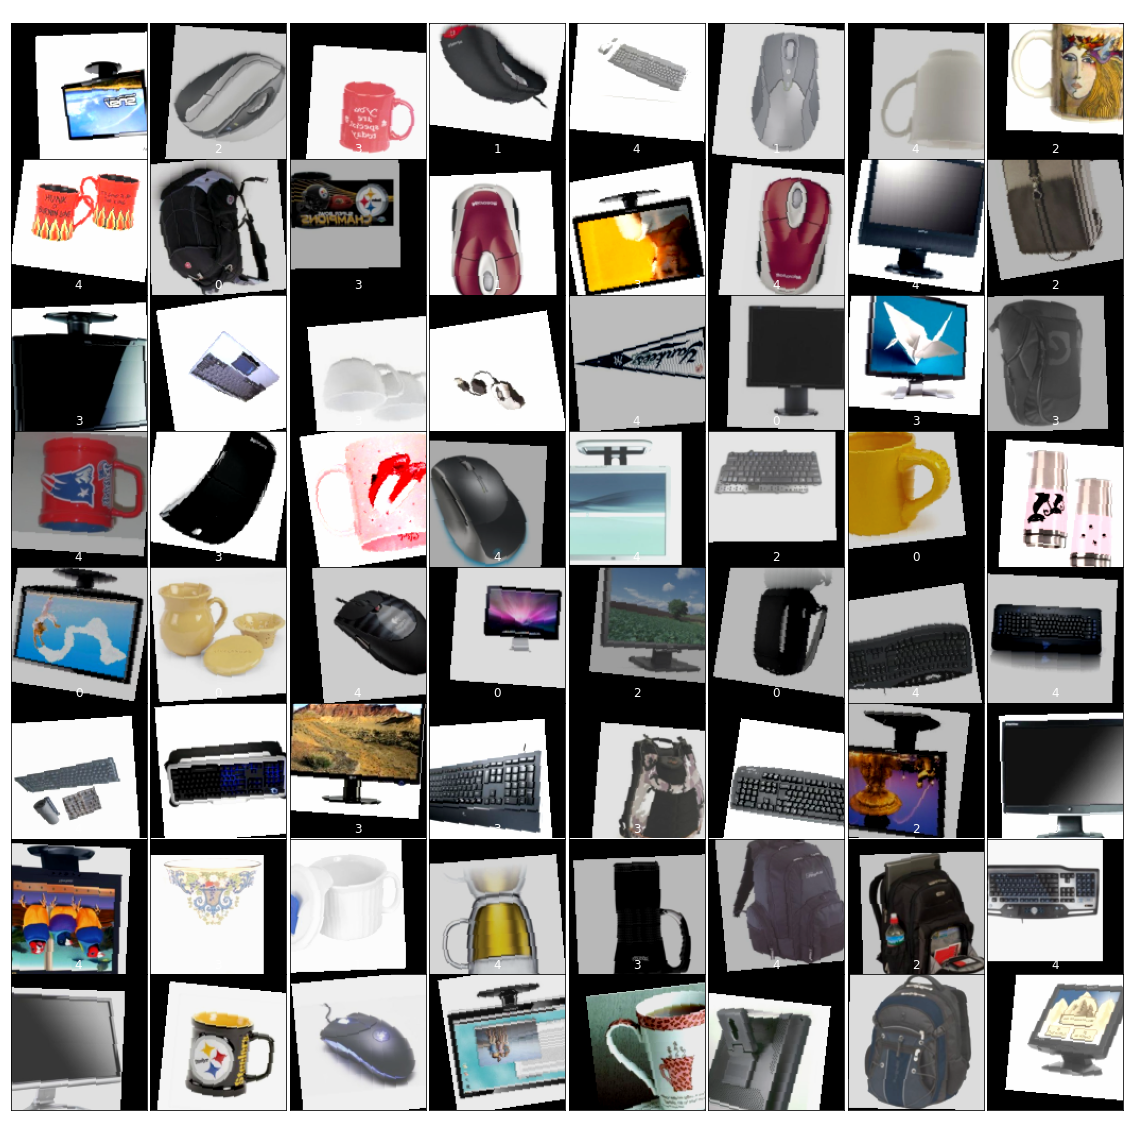

In [6]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

In [7]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=383
	validation=52
	test=49
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.65, 1.35), contrast=(0.65, 1.35), saturation=(0.65, 1.35), hue=None)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.2, 0.2))
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
)


../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


In [8]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


In [9]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------------------+
| Key                  | Type        | Value                 |
|----------------------+-------------+-----------------------|
| arch                 | str         | classifierbackbonenet |
| compression_sched    | dict        |                       |
| epoch                | int         | 29                    |
| extras               | dict        |                       |
| optimizer_state_dict | dict        |                       |
| optimizer_type       | type        | Adam                  |
| state_dict           | OrderedDict |                       |
+----------------------+-------------+-----------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | int    |      29 |
+-------+--------+---------+


Configuring device: MAX78000, simulate=False.


Number of Model Params: 287213


In [10]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[8, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({8: 1, 20: 1, 100: 1}) gamma: 0.5


In [11]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

In [12]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 383 samples (32 per mini-batch)
Epoch: [0][   12/   12]    objective_loss 1.588362    Top1 46.031746    LR 0.001000    
--- validate (epoch=0)-----------
52 samples (32 per mini-batch)
Epoch: [0][    2/    2]    Loss 1.482705    Top1 42.307692    
==> Top1: 42.308    Loss: 1.483

==> Confusion:
[[ 3  2  6  0  0]
 [ 0 10  1  0  0]
 [ 0  0  9  0  0]
 [ 0  1  5  0  0]
 [ 6  1  8  0  0]]

==> Best [Top1: 42.308 on epoch: 0]
Saving checkpoint to: jupyter_logging/finetune_office5___2022.07.07-163753/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 383 samples (32 per mini-batch)
Epoch: [1][   12/   12]    objective_loss 1.427984    Top1 46.031746    LR 0.001000    
--- validate (epoch=1)-----------
52 samples (32 per mini-batch)
Epoch: [1][    2/    2]    Loss 1.290391    Top1 50.000000    
==> Top1: 50.000    Loss: 1.290

==> Confusion:
[[7 2 2 0 0]
 [0 9 1 0 1]
 [1 1 7 0 0]
 [0 3 3 0 0]
 [6 1 5 0 3]]

==> Best [Top1: 50.000 on epoch: 1]
Saving checkpoint to: jupyter

QAT is starting!


Epoch: [8][   12/   12]    objective_loss 0.641407    Top1 74.603175    LR 0.000500    
--- validate (epoch=8)-----------
52 samples (32 per mini-batch)
Epoch: [8][    2/    2]    Loss 0.570359    Top1 84.615385    
==> Top1: 84.615    Loss: 0.570

==> Confusion:
[[ 9  1  1  0  0]
 [ 0  9  1  1  0]
 [ 0  1  8  0  0]
 [ 0  0  3  3  0]
 [ 0  0  0  0 15]]

==> Best [Top1: 84.615 on epoch: 8]
Saving checkpoint to: jupyter_logging/finetune_office5___2022.07.07-163753/classifierbackbonenet_qat_checkpoint.pth.tar
Training epoch: 383 samples (32 per mini-batch)
Epoch: [9][   12/   12]    objective_loss 0.621429    Top1 71.428571    LR 0.000500    
--- validate (epoch=9)-----------
52 samples (32 per mini-batch)
Epoch: [9][    2/    2]    Loss 0.516858    Top1 86.538462    
==> Top1: 86.538    Loss: 0.517

==> Confusion:
[[10  0  1  0  0]
 [ 0  8  2  1  0]
 [ 0  0  9  0  0]
 [ 0  0  2  4  0]
 [ 0  0  1  0 14]]

==> Best [Top1: 86.538 on epoch: 9]
Saving checkpoint to: jupyter_logging/finetune_o

## Visualize Embeddings

In [13]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False):
    _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
    preds = model(batch_imgs)
    embds = activation['fc1']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

### 1: Visualize office clusters from dataset and from camera  
* for the dataset images, set the test_batch_path to ../Datasets/test_batch_d/
* for the camera images, set the test_batch_path to ../Datasets/test_batch/  

We see that for this particular batch of images we get **68.75%** on the **camera** batch and **93.75%** on the **dataset** batch. When visualizing the output embeddings of the CNN encoder we also see that the dataset batch clusters better

In [16]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/office5/target/",conf,64,"jupyter_logging/finetune_office5___2022.07.07-163753/classifierbackbonenet_qat_checkpoint.pth.tar",model,True)

=> loading checkpoint jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------------------+
| Key                  | Type        | Value                 |
|----------------------+-------------+-----------------------|
| arch                 | str         | classifierbackbonenet |
| compression_sched    | dict        |                       |
| epoch                | int         | 29                    |
| extras               | dict        |                       |
| optimizer_state_dict | dict        |                       |
| optimizer_type       | type        | Adam                  |
| state_dict           | OrderedDict |                       |
+----------------------+-------------+-----------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | int    |      29 |
+-------+--------+---------+


../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.
batch acc:  0.65


### 2: Visualize difference in domains
* path is ../Datasets/test_batch4  

From the embeddings we can see that there is a shift between the domains, e.g. all the cat images should cluster together rather than form independent clusters based on the domain

In [17]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/office5_both/",conf,128,"jupyter_logging/finetune_office5___2022.07.07-161909/classifierbackbonenet_qat_checkpoint.pth.tar",model,False)

=> loading checkpoint jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------------------+
| Key                  | Type        | Value                 |
|----------------------+-------------+-----------------------|
| arch                 | str         | classifierbackbonenet |
| compression_sched    | dict        |                       |
| epoch                | int         | 29                    |
| extras               | dict        |                       |
| optimizer_state_dict | dict        |                       |
| optimizer_type       | type        | Adam                  |
| state_dict           | OrderedDict |                       |
+----------------------+-------------+-----------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | int    |      29 |
+-------+--------+---------+


../Datasets/office5_both/test
{'back_pack_camera': 0, 'mouse_dataset': 1, 'keyboard_dataset': 2, 'monitor_dataset': 3, 'mug_dataset': 4, 'back_pack_dataset': 5, 'keyboard_camera': 6, 'monitor_camera': 7, 'mug_camera': 8, 'mouse_camera': 9}
Configuring device: MAX78000, simulate=False.


## Quantize the model

You must change the kernel to execute within the ai8x-synthesis virtual environment

In [1]:
%load_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best.pth.tar jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best-q.pth.tar --device MAX78000 -v

Configuring device: MAX78000
Converting checkpoint file jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best.pth.tar to jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best-q.pth.tar

Model keys (state_dict):
conv1.output_shift, conv1.weight_bits, conv1.bias_bits, conv1.quantize_activation, conv1.adjust_output_shift, conv1.shift_quantile, conv1.op.weight, conv2.output_shift, conv2.weight_bits, conv2.bias_bits, conv2.quantize_activation, conv2.adjust_output_shift, conv2.shift_quantile, conv2.op.weight, conv3.output_shift, conv3.weight_bits, conv3.bias_bits, conv3.quantize_activation, conv3.adjust_output_shift, conv3.shift_quantile, conv3.op.weight, conv4.output_shift, conv4.weight_bits, conv4.bias_bits, conv4.quantize_activation, conv4.adjust_output_shift, conv4.shift_quantile, conv4.op.weight, conv4.op.bias, conv5.output_shift, conv5.weight_bits, conv5.bias_bits, conv5.quantize_activation, conv5.adjust_output_shift, conv5.shift_quantile, co

## Evaluate Quantized Model

Change virtual environment back to ai8x-training

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
load_model_path = 'jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best-q.pth.tar'

# Change this path to match file system layout
data_path = "../Datasets/cats_and_dogs/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.CatsAndDogsClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


In [3]:
args = Args(act_mode_8bit=True)

_, test_set = cats_and_dogs_get_datasets((data_path, args), load_train=True, load_test=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)

../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}


In [5]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 94.40%


## Create a sample image

In [10]:
for image, label,name in test_dataloader:
    break
im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)
np.save('../ai8x-synthesis/tests/sample_cats_and_dogs.npy', im_sample)

## Model Synthesis

In [4]:
%cd ../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix cats_and_dogs_DA --checkpoint-file ../ai8x-training/jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best-q.pth.tar --config-file networks/cats_and_dogs.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

Creating network...  ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  17%

# Now we do domain adaptation to improve the results

## Reload the modules

In [3]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## New Training Parameters for discriminator

In [4]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "officedcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "office_dcd_train"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/office5/source/"
        self.target_data_path = "../Datasets/office5/target/"
        self.deterministic = True
        self.print_freq = 100
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.001
        self.num_epochs = 32
        self.qat_policy = {'start_epoch':32, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

## Set up the logger

In [5]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/office_dcd_train___2022.07.08-092633/office_dcd_train___2022.07.08-092633.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets at 0x7f2186b99820>
num_classes=4
model_name=officedcdnet
dimensions=(1, 128)
batch_size=32
validation_split=0.1
lr=0.001000
num_epochs=32
qat_policy={'start_epoch': 32, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and Visualize the dataset

../Datasets/office5/source/train
../Datasets/office5/target/train
../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  18733  G2 =  1740  G3 =  94395  G4 =  6960
../Datasets/office5/source/test
../Datasets/office5/target/test
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  216  G2 =  196  G3 =  1176  G4 =  784


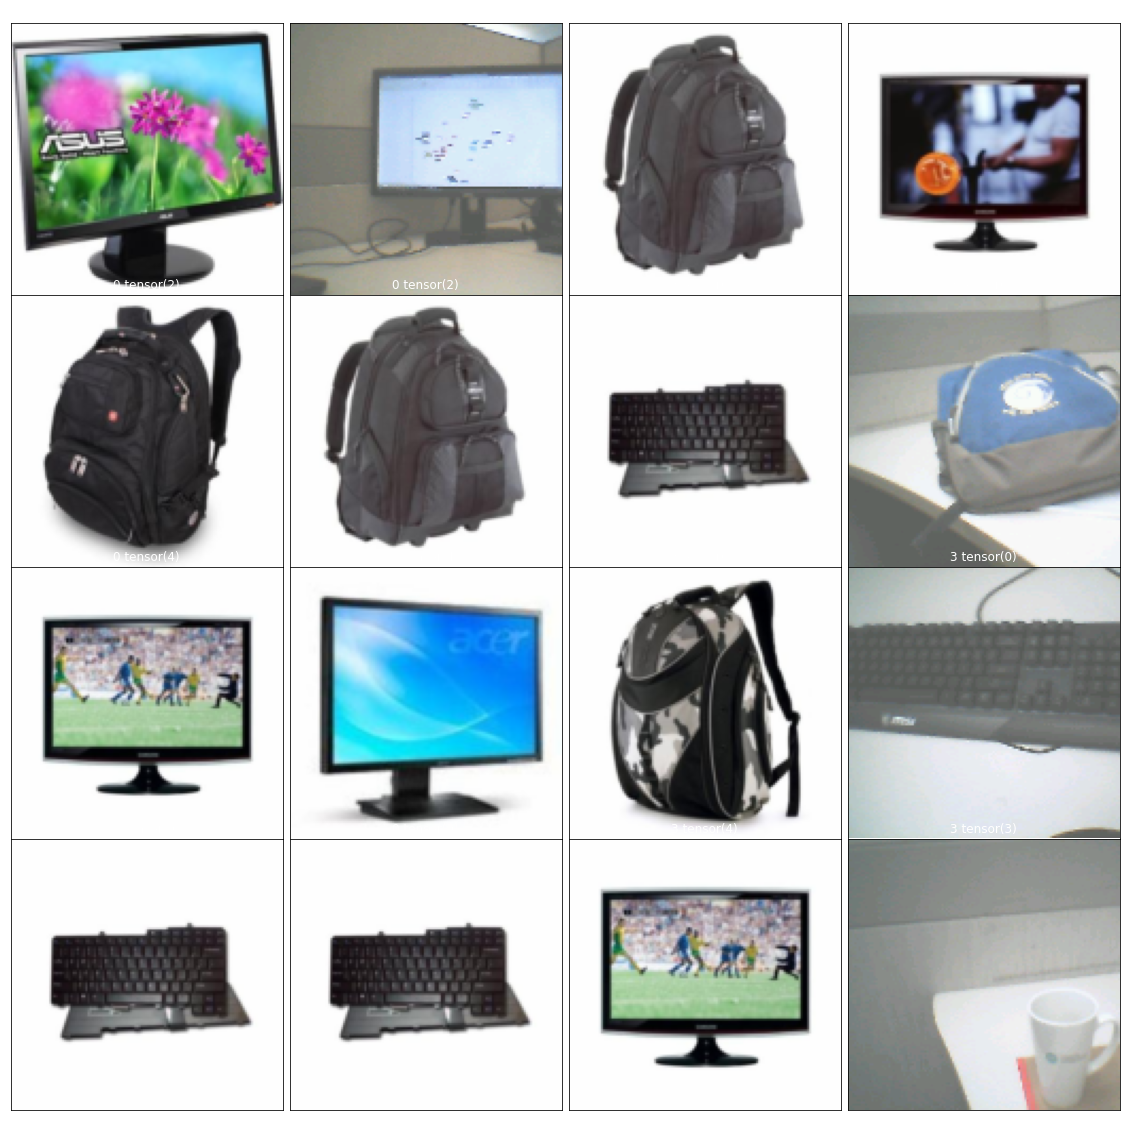

In [6]:
train_set, test_set = conf.dataset_fn(((conf.source_data_path,conf.target_data_path), args), load_train=True, load_test=True)
test_set.visualize_batch()

## Create the dataloaders

In [7]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, ((conf.source_data_path,conf.target_data_path), args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

../Datasets/office5/source/train
../Datasets/office5/target/train
../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  18733  G2 =  1740  G3 =  94395  G4 =  6960


Dataset sizes:
	training=6264
	validation=696
	test=784
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.27, 0.27))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/office5/source/test
../Datasets/office5/target/test
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  216  G2 =  196  G3 =  1176  G4 =  784


## Set up the device

In [10]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model

In [11]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeDCD()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: CatsAndDogsDCD(
  (fc1): FusedLinearReLU(
    (activate): ReLU(inplace=True)
    (op): Linear(in_features=128, out_features=64, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (fc2): Linear(
    (activate): Empty()
    (op): Linear(in_features=64, out_features=4, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
)


Configuring device: MAX78000, simulate=False.


Number of Model Params: 8516


In [12]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[10, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = torch.nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({10: 1, 35: 1, 100: 1}) gamma: 0.5


## Define the forward function

In [13]:
# load the encoder-classifier model
load_model_path = "jupyter_logging/finetune_office5___2022.07.07-161909/classifierbackbonenet_qat_checkpoint.pth.tar"
enc_model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf.device)

# register a forward hook to get the encoder output
conf.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
conf.enc_model = enc_model

def cd_DCD_forward(model, batch, conf):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

conf.forward = cd_DCD_forward

=> loading checkpoint jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------------------+
| Key                  | Type        | Value                 |
|----------------------+-------------+-----------------------|
| arch                 | str         | classifierbackbonenet |
| compression_sched    | dict        |                       |
| epoch                | int         | 29                    |
| extras               | dict        |                       |
| optimizer_state_dict | dict        |                       |
| optimizer_type       | type        | Adam                  |
| state_dict           | OrderedDict |                       |
+----------------------+-------------+-----------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | int    |      29 |
+-------+--------+---------+


In [34]:
# %load_ext autoreload
# %autoreload 2

In [15]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 6264 samples (32 per mini-batch)
Epoch: [0][  100/  196]    objective_loss 1.127192                                        LR 0.001000    
Epoch: [0][  196/  196]    objective_loss 1.033776    Top1 66.071429    LR 0.001000    
--- validate (epoch=0)-----------
696 samples (32 per mini-batch)
Epoch: [0][   22/   22]    Loss 0.875761    Top1 68.534483    
==> Top1: 68.534    Loss: 0.876

==> Confusion:
[[132   5  22   4]
 [ 28  94   3  31]
 [ 14  10 148  22]
 [ 11  32  37 103]]

==> Best [Top1: 68.534 on epoch: 0]
Saving checkpoint to: jupyter_logging/office_dcd_train___2022.07.08-092633/officedcdnet_checkpoint.pth.tar
Training epoch: 6264 samples (32 per mini-batch)
Epoch: [1][  100/  196]    objective_loss 0.811137                                        LR 0.001000    
Epoch: [1][  196/  196]    objective_loss 0.776292    Top1 71.428571    LR 0.001000    
--- validate (epoch=1)-----------
696 samples (32 per mini-batch)
Epoch: [1][   22/   22]    Loss 0.698853    Top1 7

dataset length: 784
validation step: <generator object validate.<locals>.<genexpr> at 0x7f215d5b36d0>


==> Top1: 78.819    Loss: 0.479

==> Confusion:
[[64  1 12  0]
 [ 4 54  1 14]
 [ 7  1 54  5]
 [ 0 10  6 55]]

==> Test Set [Top1: 78.819   Top5: 100.000  on test set]
Training time: 0:04:12.176595


## Now do adversarial training to trick the discriminator

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

In [2]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "officedcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 16
        self.validation_split = 0.1
        self.log_prefix = "dcd_train_adv"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/office5/source/"
        self.target_data_path = "../Datasets/office5/target/"
        self.deterministic = True
        self.print_freq = 32
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.00005
        self.num_epochs = 8
        self.qat_policy = {'start_epoch':1, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.dcd_model = None

conf_c = Config()
conf_c.num_classes = 5
conf_c.labels = ('back_pack', 'keyboard','laptop_computer','mouse','pen')
conf_c.model_name = "officeclassifier"
conf_c.dimensions = (3,128,128)
conf_c.batch_size = 32
conf_c.dataset_fn = pairs_get_datasets_c
conf_d = Config()
conf_cd = Config()

In [3]:
msglogger = apputils.config_pylogger('logging.conf', conf_c.log_prefix, conf_c.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf_c.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf_c.dataset_name,conf_c.dataset_fn,conf_c.num_classes,conf_c.model_name,conf_c.dimensions,conf_c.batch_size,conf_c.validation_split,conf_c.lr,conf_c.num_epochs,conf_c.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/dcd_train_adv___2022.07.08-100329/dcd_train_adv___2022.07.08-100329.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets_c at 0x7feb086d1af0>
num_classes=5
model_name=officeclassifier
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.1
lr=0.000050
num_epochs=8
qat_policy={'start_epoch': 1, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



In [4]:
train_loader_c, val_loader_c, test_loader_c, _ = apputils.get_data_loaders(conf_c.dataset_fn, ((conf_c.source_data_path,conf_c.target_data_path), args), conf_c.batch_size, conf_c.workers, conf_c.validation_split, conf_c.deterministic,1, 1, 1)
train_loader_d, val_loader_d, test_loader_d, _ = apputils.get_data_loaders(conf_d.dataset_fn, ((conf_c.source_data_path,conf_c.target_data_path), args), conf_d.batch_size, conf_c.workers, conf_c.validation_split, conf_c.deterministic,1, 1, 1)
_, _, test_loader, _ = apputils.get_data_loaders(cats_and_dogs_get_datasets, ("../Datasets/cats_and_dogs/",args), 32, 1, 0.1, True,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader_c.sampler), len(val_loader_c.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader_c.dataset.transform)

../Datasets/office5/source/train
../Datasets/office5/target/train
../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  18733  G2 =  1740  G3 =  94395  G4 =  6960
../Datasets/office5/source/test
../Datasets/office5/target/test
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  216  G2 =  196  G3 =  1176  G4 =  784
../Datasets/office5/source/train
../Datasets/office5/target/train
../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  18733  G2 =  1740  G3 =  94395  G4 =  696

Dataset sizes:
	training=3132
	validation=348
	test=5000
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.27, 0.27))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/office5/source/test
../Datasets/office5/target/test
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  216  G2 =  196  G3 =  1176  G4 =  784
../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}


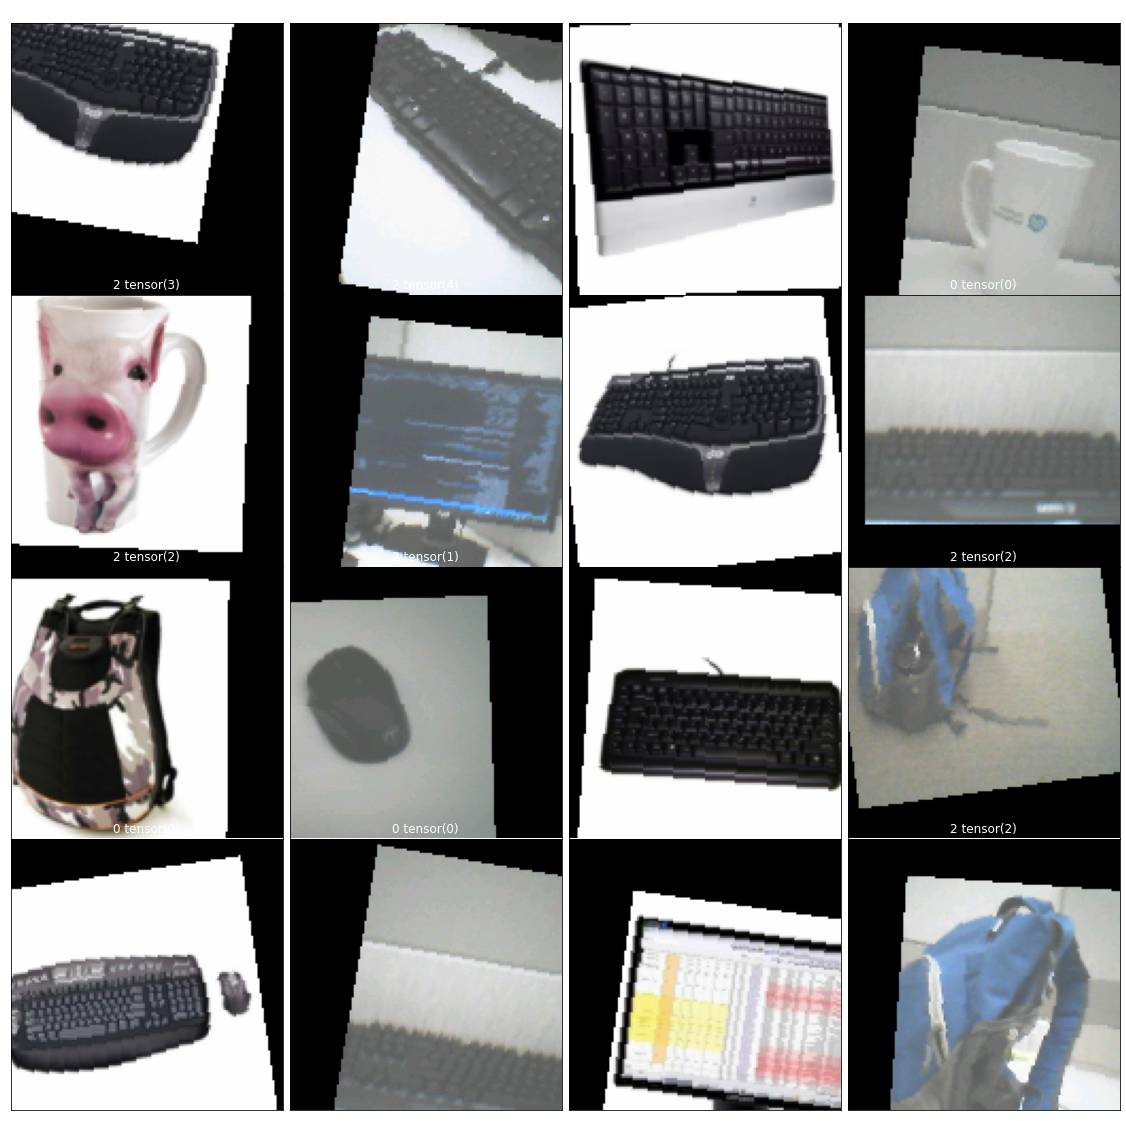

In [5]:
train_loader_c.dataset.visualize_batch()

In [6]:
conf_c.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conf_d.device = conf_c.device
print('Running on device: {}'.format(conf_c.device))

Running on device: cuda:0


In [7]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the classifier model
load_model_path = "jupyter_logging/finetune_office5___2022.07.07-163753/classifierbackbonenet_qat_checkpoint.pth.tar"
enc_model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf_c.device)

# create the DCD model
load_model_path = "jupyter_logging/office_dcd_train___2022.07.08-092633/officedcdnet_checkpoint.pth.tar"
dcd_model = mod.OfficeDCD()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(dcd_model)
dcd_model = apputils.load_lean_checkpoint(dcd_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(dcd_model)
dcd_model = dcd_model.to(conf_c.device)

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf_c.dimensions)
tflogger.tblogger.writer.add_graph(enc_model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------------------+
| Key                  | Type        | Value                 |
|----------------------+-------------+-----------------------|
| arch                 | str         | classifierbackbonenet |
| compression_sched    | dict        |                       |
| epoch                | int         | 29                    |
| extras               | dict        |                       |
| optimizer_state_dict | dict        |                       |
| optimizer_type       | type        | Adam                  |
| state_dict           | OrderedDict |                       |
+----------------------+-------------+-----------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | int    |      29 |
+-------+--------+---------+


Configuring device: MAX78000, simulate=False.


=> loaded 'state_dict' from checkpoint 'jupyter_logging/finetune_office5___2022.07.07-163753/classifierbackbonenet_qat_checkpoint.pth.tar'
=> loading checkpoint jupyter_logging/office_dcd_train___2022.07.08-092633/officedcdnet_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+--------------+
| Key                  | Type        | Value        |
|----------------------+-------------+--------------|
| arch                 | str         | officedcdnet |
| compression_sched    | dict        |              |
| epoch                | int         | 31           |
| extras               | dict        |              |
| optimizer_state_dict | dict        |              |
| optimizer_type       | type        | Adam         |
| state_dict           | OrderedDict |              |
+----------------------+-------------+--------------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+----

In [8]:
# optimizer
conf_c.optimizer = optim.Adam(enc_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_c.optimizer))

conf_d.optimizer = optim.Adam(dcd_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_d.optimizer))

# lr schedule
conf_c.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_c.optimizer, milestones=[1, 20,100], gamma=0.5)
conf_d.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_d.optimizer, milestones=[1, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf_c.lr_scheduler.base_lrs)+" milestones: "+str(conf_c.lr_scheduler.milestones)+ " gamma: "+str(conf_c.lr_scheduler.gamma))

# loss function
conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_c.device)
conf_d.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
compression_scheduler_c = distiller.CompressionScheduler(enc_model)
compression_scheduler_d = distiller.CompressionScheduler(dcd_model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [5e-05] milestones: Counter({1: 1, 20: 1, 100: 1}) gamma: 0.5


In [9]:
# register a forward hook to get the encoder output
conf_c.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf_c.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
enc_model = enc_model.to(conf_c.device)
conf_c.enc_model = enc_model

conf_d.dcd_model = dcd_model

def cd_DCD_forward(model, batch, conf, conf_c):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf_c.enc_model(inputs1)
    enc1 = conf_c.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf_c.enc_model(inputs2)
    enc2 = conf_c.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

def cd_classifier_forward(model, batch, conf, conf_d):
    inputs1, inputs2, target, imgs1_labels, imgs2_labels = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)

    # the dcd output and target as well as the classifier outputs and targets
    return conf_d.dcd_model(X_cat.detach()), target, model(inputs1), imgs1_labels, model(inputs2), imgs2_labels

def cd_classifier_forward2(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf_d.forward = cd_DCD_forward
conf_c.forward = cd_classifier_forward
conf_cd.forward = cd_classifier_forward2
conf_cd.device = conf_d.device
conf_cd.criterion = conf_c.criterion
conf_cd.num_classes = conf_c.num_classes


In [10]:
batch = next(iter(train_loader_d))
out, target = conf_d.forward(dcd_model,batch,conf_d,conf_c)
print(torch.argmax(out,axis=1)-target)

tensor([-1, -1,  0,  0,  1,  2, -2,  0, -1, -1, -1,  0, -2,  0,  0, -2],
       device='cuda:0')


In [12]:
def adv_validate(val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, loggers, epoch=-1, tflogger=-1):
    
    # store loss stats
    enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
    disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

    classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
    classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
    classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

    # validation set info
    total_samples = len(val_loader_c.sampler)
    batch_size = val_loader_c.batch_size

    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)
    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

    total_steps = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

    # Switch to evaluation mode
    classifier_model.eval()
    discriminator_model.eval()

    class_probs = []
    class_preds = []
    dcd_c_probs = []
    dcd_c_preds = []
    dcd_d_probs = []
    dcd_d_preds = []

    # iterate over the batches in the validation set
    for validation_step in range(32):
        with torch.no_grad():
            
            batch_c = next(iter(val_loader_c)) # get a single batch
            batch_d = next(iter(val_loader_d))

            # pass the input through the classifier
            dcd_out_c, dcd_target_c, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch_c, conf_c, conf_d)

            # pass the input through the dcd
            dcd_out_d, dcd_target_d = conf_d.forward(discriminator_model, batch_d, conf_d, conf_c)
            # print(conf_c.device)
            # print(conf_d.device)
            # print("model on gpu:", next(classifier_model.parameters()).is_cuda)
            # print("model on gpu:", next(discriminator_model.parameters()).is_cuda)

            # correct output for accurate loss calculation
            if conf_c.args.act_mode_8bit:
                dcd_out_c /= 128.
                dcd_out_d /= 128.
                img1_out /= 128.
                img2_out /= 128.
                for key in model.__dict__['_modules'].keys():
                    if (hasattr(model.__dict__['_modules'][key], 'wide')
                            and model.__dict__['_modules'][key].wide):
                        dcd_out_c /= 256.
                        dcd_out_d /= 256.
                        img1_out /= 256.
                        img2_out /= 256.
            
            # collect all the losses
            dcd_loss = conf_c.criterion(dcd_out_c, dcd_target_c)
            img1_loss = conf_c.criterion(img1_out, img1_target)
            img2_loss = conf_c.criterion(img2_out, img2_target)
            loss = 0.2*dcd_loss + img1_loss + img2_loss
            enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
            enc_losses['disc_c_loss'].add(dcd_loss.item())

            # collect accuracy stats
            classerr_class.add(img1_out.data, img1_target)
            classerr_class.add(img2_out.data, img2_target)
            classerr_disc_c.add(dcd_out_c.data, dcd_target_c)

            confusion_class.add(img1_out.data, img1_target)
            confusion_class.add(img2_out.data, img2_target)
            confusion_disc_c.add(dcd_out_c.data, dcd_target_c)


            dcd_loss_d = conf_d.criterion(dcd_out_d, dcd_target_d)
            disc_losses['disc_d_loss'].add(dcd_loss_d.item())

            classerr_disc_d.add(dcd_out_d.data, dcd_target_d)
            confusion_disc_d.add(dcd_out_d.data, dcd_target_d)
            

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % conf_c.print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in torch.cat((img1_out,img2_out))]
                dcd_c_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_c]
                dcd_d_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_d]

                _, class_preds_batch = torch.max(torch.cat((img1_out,img2_out)), 1)
                _, dcd_c_preds_batch = torch.max(dcd_out_c, 1)
                _, dcd_d_preds_batch = torch.max(dcd_out_d, 1)

                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)
                dcd_c_probs.append(dcd_c_probs_batch)
                dcd_c_preds.append(dcd_c_preds_batch)
                dcd_d_probs.append(dcd_d_probs_batch)
                dcd_d_preds.append(dcd_d_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Class Loss', enc_losses['class_loss'].mean),
                                 ('disc_c Loss', enc_losses['disc_c_loss'].mean),
                                 ('disc_d Loss', disc_losses['disc_d_loss'].mean),
                                    ('Class Top1', classerr_class.value(1)),
                                    ('disc_c Top1', classerr_disc_c.value(1)),
                                    ('disc_d Top1', classerr_disc_d.value(1))]),
                                    
                )
                if conf_c.num_classes > 5:
                    stats[1]['Top5'] = classerr_class.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed,
                                                total_steps, conf_c.print_freq, loggers)


    if conf_c.num_classes > 5:
        msglogger.info('==> Class Top1: %.3f    Class Top5: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0], classerr_class.value()[1],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)
    else:
        msglogger.info('==> Class Top1: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)

    msglogger.info('==> Confusion Class:\n%s\n', str(confusion_class.value()))
    msglogger.info('==> Confusion DCD_c:\n%s\n', str(confusion_disc_c.value()))
    msglogger.info('==> Confusion DCD_d:\n%s\n', str(confusion_disc_d.value()))

    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion_class.value(), conf_c.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_class', cf, epoch,
                                            dataformats='HWC')
        cf = nnplot.confusion_matrix(confusion_disc_c.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_c', cf, epoch,
                                            dataformats='HWC')

        cf = nnplot.confusion_matrix(confusion_disc_d.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_d', cf, epoch,
                                            dataformats='HWC')
    
    return classerr_class.value(1), classerr_class.value(min(conf_c.num_classes, 5)), enc_losses['class_loss'].mean, classerr_disc_c.value(1), enc_losses['disc_c_loss'].mean, classerr_disc_d.value(1), disc_losses['disc_d_loss'].mean

In [13]:
def adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, conf_cd):

    # store model history across epochs
    perf_scores_history = []

    classifier_model = classifier_model.to(conf_c.device)
    discriminator_model = discriminator_model.to(conf_d.device)

    # start the clock
    tic = datetime.now()

    batches_per_phase = 1

    # =============================== training loop =====================================
    for epoch in range(0, conf_c.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf_c.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(classifier_model)
            ai8x.fuse_bn_layers(discriminator_model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(classifier_model, conf_c.qat_policy)
            ai8x.initiate_qat(discriminator_model, conf_d.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            classifier_model.to(conf_c.device)
            discriminator_model.to(conf_d.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf_c.model_name = f'{conf_c.model_name}_qat'
            conf_d.model_name = f'{conf_d.model_name}_qat'

        # store loss and training stats
        enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
        disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

        classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
        classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
        classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

        # logging stats
        total_samples = len(train_loader_c.sampler)
        steps_per_epoch = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

        # Switch to train mode
        classifier_model.train()
        discriminator_model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        encoder_on = False
        switch_d = False
        switch_c = False

        print("steps in an epoch:", len(train_loader_c))

        #for train_step, batch in enumerate(train_loader_c):
        for train_step in range(64): # reduce epocj to 64 batches since we are randomly sampling
            # switch phase every four batches
            if (train_step % batches_per_phase) == 0:
                if encoder_on == True: # switch to train dcd
                    switch_d = True
                if encoder_on == False: # switch to train encoder
                    switch_c = True
                encoder_on = not encoder_on

            # train the encoder to trick the discriminator
            if encoder_on:
                if switch_c == True: # create new error collectors at the start of the phase
                    switch_c = False
                    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
                    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_c)) # get a single batch

                # pass the input through the classifier
                dcd_out, dcd_target, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch, conf_c, conf_d) 
                
                # collect all the losses
                dcd_loss = conf_c.criterion(dcd_out, dcd_target)
                img1_loss = conf_c.criterion(img1_out, img1_target)
                img2_loss = conf_c.criterion(img2_out, img2_target)
                loss = 0.1*dcd_loss + img1_loss + img2_loss

                # collect accuracy stats
                classerr_class.add(img1_out.data, img1_target)
                classerr_class.add(img2_out.data, img2_target)
                classerr_disc_c.add(dcd_out.data, dcd_target)

                confusion_class.add(img1_out.data, img1_target)
                confusion_class.add(img2_out.data, img2_target)
                confusion_disc_c.add(dcd_out.data, dcd_target)
                
                # add the losses
                enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
                enc_losses['disc_c_loss'].add(dcd_loss.item())

                # reset the optimizer
                conf_c.optimizer.zero_grad()

                # backwards pass and parameter update
                loss.backward()
                conf_c.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats
                if (steps_completed+batches_per_phase) % conf_c.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_class.n != 0:
                        errs['class Top1'] = classerr_class.value(1)
                        errs['disc_c Top1'] = classerr_disc_c.value(1)
                        if conf_c.num_classes > 5:
                            errs['class Top5'] = classerr_class.value(5)
                    else:
                        errs['class Top1'] = None
                        errs['class Top5'] = None
                        errs['disc_c Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in enc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_c.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_c/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_c.print_freq,all_loggers)

            # train the discriminator
            else:
                if switch_d == True:
                    switch_d = False
                    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_d))

                # pass the input through the dcd
                dcd_out, dcd_target = conf_d.forward(discriminator_model, batch, conf_d, conf_c) 
                
                dcd_loss_d = conf_d.criterion(dcd_out, dcd_target)

                classerr_disc_d.add(dcd_out.data, dcd_target)
                confusion_disc_d.add(dcd_out.data, dcd_target)
                
                disc_losses['disc_d_loss'].add(dcd_loss_d.item())

                # reset the optimizer
                conf_d.optimizer.zero_grad()

                # backwards pass and parameter update
                dcd_loss_d.backward()
                conf_d.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats every 10 batches
                if steps_completed % conf_d.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_disc_d.n != 0:
                        errs['disc_d Top1'] = classerr_disc_d.value(1)
                    else:
                        errs['disc_d Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in disc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_d.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_d/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_d.print_freq,all_loggers)


        # ============================= validation =======================
        msglogger.info('--- validate (epoch=%d)-----------', epoch)
        class_top1, class_top5, class_loss, disc_c_top1, disc_c_loss, disc_d_top1, disc_d_loss = adv_validate(val_loader_c, val_loader_d, classifier_model,\
                                                                                                          conf_c, discriminator_model, conf_d, [pylogger], epoch, tflogger)

        # store validation stats
        stats = (
                    'Adv/Validation/',
                    OrderedDict([('Class Loss', class_loss),
                                 ('disc_c Loss', disc_c_loss),
                                 ('disc_d Loss', disc_d_loss),
                                    ('Class Top1', class_top1),
                                    ('disc_c Top1', disc_c_top1),
                                    ('disc_d Top1', disc_d_top1)]),
                                    
                )
        
        if conf_c.num_classes > 5:
            stats[1]['Top5'] = classerr_class.value(5)

        distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                log_freq=1, loggers=all_tbloggers)

        perf_scores_history.append(distiller.MutableNamedTuple({'disc_top1_diff': disc_c_top1-disc_d_top1, 'epoch': epoch}))
        # Keep perf_scores_history sorted from best to worst
        # Sort by top1 as main sort key, then sort by top5 and epoch
        perf_scores_history.sort(key=operator.attrgetter('disc_top1_diff','epoch'),reverse=True)
        for score in perf_scores_history[:1]:
            msglogger.info('==> Best [disc_top1_diff: %.3f on epoch: %d]',
                            score.disc_top1_diff, score.epoch)

        # Save the checkpoint
        is_best = epoch == perf_scores_history[0].epoch
        checkpoint_extras = {'current_top1': disc_c_top1-disc_d_top1,
                            'best_top1': perf_scores_history[0].disc_top1_diff,
                            'best_epoch': perf_scores_history[0].epoch}

        apputils.save_checkpoint(epoch, conf_c.model_name, classifier_model, optimizer=conf_c.optimizer,
                                    scheduler=compression_scheduler_c, extras=checkpoint_extras,
                                    is_best=is_best, name=conf_c.model_name,
                                    dir=msglogger.logdir)

        conf_c.lr_scheduler.step()
        conf_d.lr_scheduler.step()

    # ========================= test ============================
    # top1, top5, losses = validate(val_loader, model, [pylogger], conf, epoch, tflogger)
    # msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

In [14]:
adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, enc_model, conf_c, dcd_model, conf_d, conf_cd)

Training epoch: 3132 samples (32 per mini-batch)


steps in an epoch: 98


Epoch: [0][   31/   98]    class_loss 0.911427    disc_c_loss 0.782379    class Top1 85.937500    disc_c Top1 64.062500    LR 0.000050    
Epoch: [0][   32/   98]    disc_d_loss 2.548257    disc_d Top1 39.453125    LR 0.000050    
Epoch: [0][   63/   98]    class_loss 0.658347    disc_c_loss 0.680063    class Top1 90.332031    disc_c Top1 70.800781    LR 0.000050    
Epoch: [0][   64/   98]    disc_d_loss 2.365261    disc_d Top1 41.601562    LR 0.000050    
--- validate (epoch=0)-----------
348 samples (32 per mini-batch)
Epoch: [0][   11/   11]    Class Loss 0.311333    disc_c Loss 0.570246    disc_d Loss 1.874285    Class Top1 95.880682    disc_c Top1 78.409091    disc_d Top1 47.159091    
Epoch: [0][   32/   11]    Class Loss 0.310243    disc_c Loss 0.551194    disc_d Loss 2.258624    Class Top1 96.044922    disc_c Top1 79.199219    disc_d Top1 43.945312    
==> Class Top1: 96.045    Class Loss: 0.310    DCD_c Top1: 79.199 DCD_c Loss: 0.551    DCD_d Top1: 43.945 DCD_d Loss: 2.259

=

QAT is starting!
steps in an epoch: 98


Epoch: [1][   31/   98]    class_loss 0.265059    disc_c_loss 0.896008    class Top1 96.386719    disc_c Top1 78.125000    LR 0.000025    
Epoch: [1][   32/   98]    disc_d_loss 1.283653    disc_d Top1 46.484375    LR 0.000025    
Epoch: [1][   63/   98]    class_loss 0.250380    disc_c_loss 0.892798    class Top1 96.484375    disc_c Top1 79.003906    LR 0.000025    
Epoch: [1][   64/   98]    disc_d_loss 1.287114    disc_d Top1 45.507812    LR 0.000025    
--- validate (epoch=1)-----------
348 samples (32 per mini-batch)
Epoch: [1][   11/   11]    Class Loss 0.213507    disc_c Loss 0.897676    disc_d Loss 1.285062    Class Top1 97.585227    disc_c Top1 80.113636    disc_d Top1 43.750000    
Epoch: [1][   32/   11]    Class Loss 0.218172    disc_c Loss 0.886566    disc_d Loss 1.262888    Class Top1 97.412109    disc_c Top1 81.640625    disc_d Top1 46.093750    
==> Class Top1: 97.412    Class Loss: 0.218    DCD_c Top1: 81.641 DCD_c Loss: 0.887    DCD_d Top1: 46.094 DCD_d Loss: 1.263

=

steps in an epoch: 98


Epoch: [2][   31/   98]    class_loss 0.197542    disc_c_loss 0.894506    class Top1 97.949219    disc_c Top1 77.343750    LR 0.000025    
Epoch: [2][   32/   98]    disc_d_loss 1.307400    disc_d Top1 43.750000    LR 0.000025    
Epoch: [2][   63/   98]    class_loss 0.170497    disc_c_loss 0.886826    class Top1 98.535156    disc_c Top1 78.808594    LR 0.000025    
Epoch: [2][   64/   98]    disc_d_loss 1.277053    disc_d Top1 47.656250    LR 0.000025    
--- validate (epoch=2)-----------
348 samples (32 per mini-batch)
Epoch: [2][   11/   11]    Class Loss 0.132126    disc_c Loss 0.874356    disc_d Loss 1.276522    Class Top1 99.431818    disc_c Top1 80.397727    disc_d Top1 48.863636    
Epoch: [2][   32/   11]    Class Loss 0.132746    disc_c Loss 0.870196    disc_d Loss 1.317108    Class Top1 99.218750    disc_c Top1 80.371094    disc_d Top1 47.656250    
==> Class Top1: 99.219    Class Loss: 0.133    DCD_c Top1: 80.371 DCD_c Loss: 0.870    DCD_d Top1: 47.656 DCD_d Loss: 1.317

=

steps in an epoch: 98


Epoch: [3][   31/   98]    class_loss 0.121451    disc_c_loss 0.861427    class Top1 99.511719    disc_c Top1 81.445312    LR 0.000025    
Epoch: [3][   32/   98]    disc_d_loss 1.301734    disc_d Top1 48.437500    LR 0.000025    
Epoch: [3][   63/   98]    class_loss 0.110931    disc_c_loss 0.855330    class Top1 99.755859    disc_c Top1 82.031250    LR 0.000025    
Epoch: [3][   64/   98]    disc_d_loss 1.319530    disc_d Top1 47.656250    LR 0.000025    
--- validate (epoch=3)-----------
348 samples (32 per mini-batch)
Epoch: [3][   11/   11]    Class Loss 0.108257    disc_c Loss 0.857388    disc_d Loss 1.286591    Class Top1 100.000000    disc_c Top1 78.977273    disc_d Top1 50.568182    
Epoch: [3][   32/   11]    Class Loss 0.099276    disc_c Loss 0.856287    disc_d Loss 1.289897    Class Top1 100.000000    disc_c Top1 80.371094    disc_d Top1 48.828125    
==> Class Top1: 100.000    Class Loss: 0.099    DCD_c Top1: 80.371 DCD_c Loss: 0.856    DCD_d Top1: 48.828 DCD_d Loss: 1.290

steps in an epoch: 98


Epoch: [4][   31/   98]    class_loss 0.095669    disc_c_loss 0.844933    class Top1 100.000000    disc_c Top1 81.640625    LR 0.000025    
Epoch: [4][   32/   98]    disc_d_loss 1.281183    disc_d Top1 48.437500    LR 0.000025    
Epoch: [4][   63/   98]    class_loss 0.085356    disc_c_loss 0.840742    class Top1 100.000000    disc_c Top1 83.203125    LR 0.000025    
Epoch: [4][   64/   98]    disc_d_loss 1.293423    disc_d Top1 48.828125    LR 0.000025    
--- validate (epoch=4)-----------
348 samples (32 per mini-batch)
Epoch: [4][   11/   11]    Class Loss 0.076384    disc_c Loss 0.858203    disc_d Loss 1.318026    Class Top1 100.000000    disc_c Top1 81.250000    disc_d Top1 46.022727    
Epoch: [4][   32/   11]    Class Loss 0.072651    disc_c Loss 0.851394    disc_d Loss 1.305408    Class Top1 100.000000    disc_c Top1 82.714844    disc_d Top1 46.289062    
==> Class Top1: 100.000    Class Loss: 0.073    DCD_c Top1: 82.715 DCD_c Loss: 0.851    DCD_d Top1: 46.289 DCD_d Loss: 1.3

steps in an epoch: 98


Epoch: [5][   31/   98]    class_loss 0.071398    disc_c_loss 0.845932    class Top1 100.000000    disc_c Top1 82.031250    LR 0.000025    
Epoch: [5][   32/   98]    disc_d_loss 1.338492    disc_d Top1 45.312500    LR 0.000025    
Epoch: [5][   63/   98]    class_loss 0.066604    disc_c_loss 0.843369    class Top1 100.000000    disc_c Top1 82.617188    LR 0.000025    
Epoch: [5][   64/   98]    disc_d_loss 1.291575    disc_d Top1 48.632812    LR 0.000025    
--- validate (epoch=5)-----------
348 samples (32 per mini-batch)
Epoch: [5][   11/   11]    Class Loss 0.063351    disc_c Loss 0.846467    disc_d Loss 1.342946    Class Top1 100.000000    disc_c Top1 81.818182    disc_d Top1 41.477273    
Epoch: [5][   32/   11]    Class Loss 0.062961    disc_c Loss 0.845494    disc_d Loss 1.326418    Class Top1 100.000000    disc_c Top1 81.640625    disc_d Top1 46.875000    
==> Class Top1: 100.000    Class Loss: 0.063    DCD_c Top1: 81.641 DCD_c Loss: 0.845    DCD_d Top1: 46.875 DCD_d Loss: 1.3

steps in an epoch: 98


Epoch: [6][   31/   98]    class_loss 0.060893    disc_c_loss 0.845376    class Top1 100.000000    disc_c Top1 81.250000    LR 0.000025    
Epoch: [6][   32/   98]    disc_d_loss 1.203506    disc_d Top1 55.468750    LR 0.000025    
Epoch: [6][   63/   98]    class_loss 0.058555    disc_c_loss 0.848370    class Top1 100.000000    disc_c Top1 81.640625    LR 0.000025    
Epoch: [6][   64/   98]    disc_d_loss 1.217331    disc_d Top1 53.515625    LR 0.000025    
--- validate (epoch=6)-----------
348 samples (32 per mini-batch)
Epoch: [6][   11/   11]    Class Loss 0.056091    disc_c Loss 0.846097    disc_d Loss 1.214370    Class Top1 100.000000    disc_c Top1 82.670455    disc_d Top1 53.409091    
Epoch: [6][   32/   11]    Class Loss 0.054969    disc_c Loss 0.850446    disc_d Loss 1.247300    Class Top1 100.000000    disc_c Top1 82.226562    disc_d Top1 49.609375    
==> Class Top1: 100.000    Class Loss: 0.055    DCD_c Top1: 82.227 DCD_c Loss: 0.850    DCD_d Top1: 49.609 DCD_d Loss: 1.2

steps in an epoch: 98


Epoch: [7][   31/   98]    class_loss 0.050498    disc_c_loss 0.840062    class Top1 100.000000    disc_c Top1 83.203125    LR 0.000025    
Epoch: [7][   32/   98]    disc_d_loss 1.227542    disc_d Top1 56.250000    LR 0.000025    
Epoch: [7][   63/   98]    class_loss 0.050691    disc_c_loss 0.846399    class Top1 100.000000    disc_c Top1 83.593750    LR 0.000025    
Epoch: [7][   64/   98]    disc_d_loss 1.273784    disc_d Top1 51.367188    LR 0.000025    
--- validate (epoch=7)-----------
348 samples (32 per mini-batch)
Epoch: [7][   11/   11]    Class Loss 0.049912    disc_c Loss 0.843710    disc_d Loss 1.265767    Class Top1 100.000000    disc_c Top1 83.522727    disc_d Top1 46.590909    
Epoch: [7][   32/   11]    Class Loss 0.049156    disc_c Loss 0.859860    disc_d Loss 1.208102    Class Top1 100.000000    disc_c Top1 81.835938    disc_d Top1 53.515625    
==> Class Top1: 100.000    Class Loss: 0.049    DCD_c Top1: 81.836 DCD_c Loss: 0.860    DCD_d Top1: 53.516 DCD_d Loss: 1.2

## Visualize embeddings again

In [22]:
def adv_viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False,dataset_fn=None):
    if dataset_fn != None:
        _, test_set = dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    else:
        _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.feature_extractor.fc2.register_forward_hook(get_activation('fc2'))
    preds = model(batch_imgs)
    embds = activation['fc2']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

In [28]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
adv_viz_embeddings("../Datasets/office5/target/",conf_c,128,"jupyter_logging/dcd_train_adv___2022.07.08-100329/officeclassifier_qat_best.pth.tar",model,True,office5_get_datasets)

=> loading checkpoint jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------------------+
| Key                  | Type        | Value                 |
|----------------------+-------------+-----------------------|
| arch                 | str         | classifierbackbonenet |
| compression_sched    | dict        |                       |
| epoch                | int         | 29                    |
| extras               | dict        |                       |
| optimizer_state_dict | dict        |                       |
| optimizer_type       | type        | Adam                  |
| state_dict           | OrderedDict |                       |
+----------------------+-------------+-----------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | int    |      29 |
+-------+--------+---------+


../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.
batch acc:  0.85
